# Final Project

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:

## Part 0 -  Utiles

### Importing the libraries

In [1]:
import os
import gdown
import torch
import random
import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

!gdown --id 1GsqEEsXnv7zXYwK2PJIX_5-7WVz4o53U
gdown.download(
    "https://drive.google.com/uc?export=download&confirm=pbef&id=1taRnS_VkYrls0pMDMdjwQUQYo0PzttL7"
)
!unzip /content/dataset.zip


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GsqEEsXnv7zXYwK2PJIX_5-7WVz4o53U
To: /content/ae_model.pth
100% 2.99M/2.99M [00:00<00:00, 224MB/s]


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1taRnS_VkYrls0pMDMdjwQUQYo0PzttL7
To: /content/dataset.zip
100%|██████████| 106M/106M [00:01<00:00, 79.5MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: dataset/photo_jpg/23568b7cf6.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._23568b7cf6.jpg  
  inflating: dataset/photo_jpg/a2635ee772.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._a2635ee772.jpg  
  inflating: dataset/photo_jpg/ce5b830de2.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._ce5b830de2.jpg  
  inflating: dataset/photo_jpg/d7b0822c4d.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._d7b0822c4d.jpg  
  inflating: dataset/photo_jpg/30126b0c64.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._30126b0c64.jpg  
  inflating: dataset/photo_jpg/a3e41f7a46.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._a3e41f7a46.jpg  
  inflating: dataset/photo_jpg/d4e9f0b0ce.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._d4e9f0b0ce.jpg  
  inflating: dataset/photo_jpg/8f250ece01.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._8f250ece01.jpg  
  inflating: dataset/photo_jpg/62428234ef.jpg  
  inflating: __MACOSX/dataset/photo_jpg/._624

###Use cuda if available


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Part 1 - Data Preprocessing



###Importing the dataset

Data example:


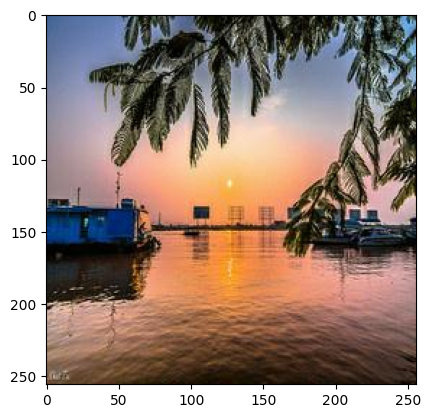

In [3]:
class ImagesLoader(Dataset):
  def __init__(self,path) -> None:
    self.path = path
    self.images = os.listdir(path)
    self.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    ])

  def __len__(self) -> int:
    return len(self.images)


  def init(self,stop=10000):
    imgs = []
    for idx,_ in enumerate(self.images[:stop]):
        img = self.images[idx % len(self.images)]
        image_path = os.path.join(self.path, img)
        img =  Image.open(image_path).convert('RGB')
        img = self.transform(img)
        imgs.append(img)
    return imgs
  def __getitem__(self, idx):
    img = self.images[idx % len(self.images)]
    image_path = os.path.join(self.path, img)
    img =  Image.open(image_path).convert('RGB')
    img = self.transform(img)
    return img

monet_data=ImagesLoader("/content/dataset/monet_jpg")
photo_data=ImagesLoader("/content/dataset/photo_jpg")

print("Data example:")
for i in range(5):
  plt.imshow(photo_data[i].permute(1, 2, 0))


Running model training.

In [4]:
images = monet_data.init()
monets = torch.stack(images)
# images = photo_data.init()
# photo_data = torch.stack(images)

In [5]:
print(monets.shape)

torch.Size([300, 3, 256, 256])


## Part 2 - Condensating data set by augmentation.

### Augment moent train images

torch.Size([600, 3, 256, 256])


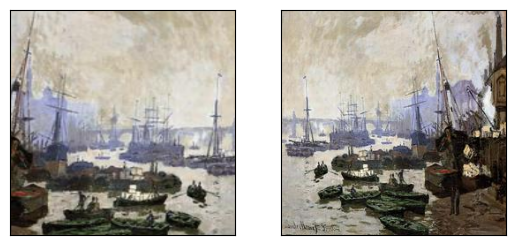

In [6]:
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transforms_crop = torch.nn.Sequential(
    T.RandomResizedCrop(256,(0.1,0.7)),
    T.RandomHorizontalFlip(p=0.2),
)
transform_flip=torch.nn.Sequential(
    T.RandomResizedCrop(256,(0.90,1)),
    T.RandomHorizontalFlip(p=0.2),
)
monets=monets.to(device)
def augment():
    return torch.cat((transforms_crop(monets),transform_flip(monets)),0)

transformed=augment()
print(transformed.shape)
show([transformed[2], monets[2]])
monet_train=torch.cat((monets,transformed),0)

In [7]:
print(monets.shape)
print(monet_train.shape)

torch.Size([300, 3, 256, 256])
torch.Size([900, 3, 256, 256])


In [8]:
print(transformed.shape)

torch.Size([600, 3, 256, 256])


In [9]:
class TrainDataset(Dataset):
    def __init__(self, monet_ds, photo_ds):
        self.monet_ds = monet_ds
        self.photo_ds = photo_ds

    def __len__(self):
        return max(len(self.monet_ds), len(self.photo_ds))

    def __getitem__(self, idx):
        monet_idx = idx % len(self.monet_ds)
        photo_idx = idx % len(self.photo_ds)

        monet_img = self.monet_ds[monet_idx]
        photo_img = self.photo_ds[photo_idx]

        return monet_img, photo_img

#### Show monet dataset sample

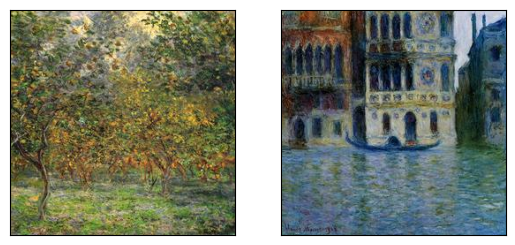

In [10]:
show(monet_train[:2])
train_dataset=TrainDataset(monet_train,photo_data)

#### Show plain dataset sample

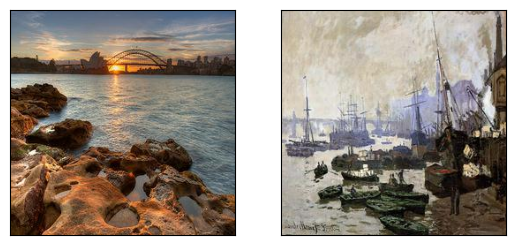

In [11]:
show([photo_data[2], monet_train[2]])


In [12]:
monet_img, photo_img = train_dataset.__getitem__(0)
print(monet_img.shape)
print(photo_img.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


## Part 3 - Neural Style Transfer set-up

### imports

In [13]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


### Load Pics

In [14]:
imsize = 256 #512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

to_pil = T.ToPILImage()

def image_loader(image):
    # convert the tensor to PIL image using above transform
    image = to_pil(image)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# define a transform to convert a tensor to PIL image
to_pil = T.ToPILImage()

# convert the tensor to PIL image using above transform
img = to_pil(monet_train[3])
# display the PIL image
img.show()

style_img = image_loader(monet_train[3])
content_img = image_loader(photo_data[3])

print(style_img.size())
content_img.clone()
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"



torch.Size([1, 3, 256, 256])


###Show pic

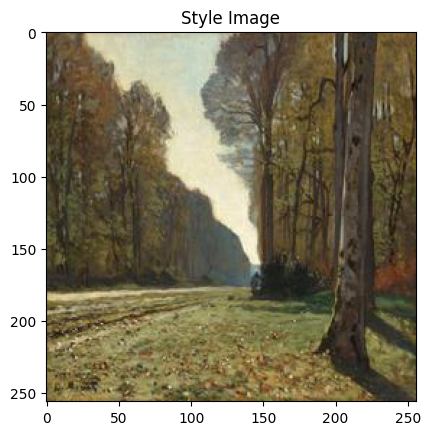

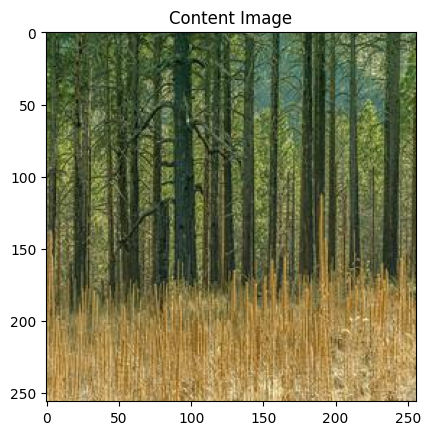

In [15]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


###Netork Layout

## Part 4 - Cycle GAN


###Blocks

In [16]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(f, f, 3, 1, 1),
            nn.InstanceNorm2d(f),
            nn.ReLU(),

            nn.Conv2d(f, f, 3, 1, 1),
        )

        self.norm = nn.InstanceNorm2d(f)

    def forward(self, x):
        return torch.relu(self.conv(x) + x)


###Generator

In [17]:
class Generator(nn.Module):
    def __init__(self, f=64, res_blocks=6):
        super(Generator, self).__init__()
        layers = []

        layers.extend([
            nn.Conv2d(3, f, 7, 1, 3),
            nn.InstanceNorm2d(f),
            nn.ReLU(True),

            nn.Conv2d(f, f * 2, 3, 2, 1),
            nn.InstanceNorm2d(f * 2),
            nn.ReLU(True),

            nn.Conv2d(f * 2, f * 4, 3, 2, 1),
            nn.InstanceNorm2d(f * 4),
            nn.ReLU(True)
        ])

        for i in range(res_blocks):
            layers.append(ResBlock(f * 4))

        layers.extend([
            nn.ConvTranspose2d(f * 4, f * 2 * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(f * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(f * 2, f * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(f),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(f, 3, 7, 1, 0),
            nn.Tanh()

        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

###Discriminator

In [18]:
import torch.nn.functional as F
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=1, padding=1)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x = self.conv5(x)
        return x


###Object initialize


In [19]:
disc_M = Discriminator().to(device)
disc_P = Discriminator().to(device)

gen_M = Generator().to(device)
gen_P = Generator().to(device)

opt_disc = torch.optim.Adam(
    list(disc_M.parameters()) + list(disc_P.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

opt_gen = torch.optim.Adam(
    list(gen_M.parameters()) + list(gen_P.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

l1 = nn.L1Loss()
mse = nn.MSELoss()
loader = DataLoader(train_dataset , batch_size=1, shuffle=True)

###Train cycle gan

In [20]:
num_epochs = 1
D_loss_arr=[]
G_loss_arr=[]

for epoch in range(num_epochs):
    loop = tqdm(loader, leave=True)

    for idx, (monet, photo) in enumerate(loop):
        #limit beacuse we have no gpu
        monet = monet.to(device)
        photo = photo.to(device)
        # print("monet ",monet.shape)
        # print("photo ",photo.shape)
        fake_photo = gen_P(monet)
        # print("fake_photo",fake_photo.shape)
        D_P_real = disc_P(photo)
        # print("D_P_real",D_P_real.shape)
        D_P_fake = disc_P(fake_photo.detach())
        # print("D_P_fake",D_P_fake.shape)
        D_P_real_loss = mse(D_P_real, torch.ones(len(D_P_real)).to(device))
        # print("D_P_real_loss",D_P_real_loss.shape)
        D_P_fake_loss = mse(D_P_fake, torch.zeros(len(D_P_fake)).to(device))
        # print("D_P_fake_loss",D_P_fake_loss.shape)
        D_P_loss = D_P_real_loss + D_P_fake_loss

        fake_monet = gen_M(photo)
        # print("fake_monet",fake_monet.shape)
        D_M_real = disc_M(monet)
        # print("D_M_real",D_M_real.shape)
        D_M_fake = disc_M(fake_monet.detach())
        # print("D_M_fake",D_M_fake.shape)
        D_M_real_loss = mse(D_M_real, torch.ones(len(D_M_real)).to(device))
        #pdb.set_trace()
        D_M_fake_loss = mse(D_M_fake, torch.zeros(len(D_M_fake)).to(device))
        D_M_loss = D_M_real_loss + D_M_fake_loss

        D_loss = (D_P_loss + D_M_loss) / 2
        D_loss_arr.append(D_loss.item())
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        D_P_fake = disc_P(fake_photo)
        D_M_fake = disc_M(fake_monet)
        loss_G_P = mse(D_P_fake, torch.ones(len(D_P_fake)).to(device))
        loss_G_M = mse(D_M_fake, torch.ones(len(D_M_fake)).to(device))

        cycle_photo = gen_P(fake_monet)
        cycle_monet = gen_M(fake_photo)
        cycle_photo_loss = l1(photo, cycle_photo)
        cycle_monet_loss = l1(monet, cycle_monet)

        identity_photo = gen_P(photo)
        identity_monet = gen_M(monet)
        identity_photo_loss = l1(photo, identity_photo)
        identity_monet_loss = l1(monet, identity_monet)

        G_loss = (
            loss_G_P
            + loss_G_M
            + cycle_photo_loss * 10
            + cycle_monet_loss * 10
             + identity_photo_loss
            + identity_monet_loss
        )
        G_loss_arr.append(G_loss.item())
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        if idx % 200 == 0:
            print(
                'G_P_loss:', loss_G_P.cpu().detach().item(),
                'G_M_loss:', loss_G_M.cpu().detach().item(),
                'D_M_loss:', D_M_loss.cpu().detach().item(),
                'D_P_loss:', D_P_loss.cpu().detach().item()
            )
            print(f"G_loss {idx} = ",G_loss)
            print(f"D_loss {idx} = ",D_loss)
    print(f"Final epoch {epoch} G_loss {idx} = ",G_loss)
    print(f"Final epoch {epoch} D_loss {idx} = ",D_loss)

  0%|          | 0/7038 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


G_P_loss: 0.8402075171470642 G_M_loss: 0.8202859163284302 D_M_loss: 0.9700555205345154 D_P_loss: 1.0004736185073853
G_loss 0 =  

  0%|          | 1/7038 [00:02<4:39:50,  2.39s/it]

tensor(14.2702, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 0 =  tensor(0.9853, device='cuda:0', grad_fn=<DivBackward0>)


  3%|▎         | 201/7038 [01:37<1:00:57,  1.87it/s]

G_P_loss: 0.18137729167938232 G_M_loss: 0.437301903963089 D_M_loss: 0.2523290514945984 D_P_loss: 0.45064300298690796
G_loss 200 =  tensor(5.5969, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 200 =  tensor(0.3515, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 401/7038 [03:12<59:31,  1.86it/s]

G_P_loss: 0.7337235808372498 G_M_loss: 0.2722513675689697 D_M_loss: 0.5583133697509766 D_P_loss: 0.7871558666229248
G_loss 400 =  tensor(4.3566, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 400 =  tensor(0.6727, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▊         | 601/7038 [04:47<57:56,  1.85it/s]

G_P_loss: 0.34683337807655334 G_M_loss: 0.3595026433467865 D_M_loss: 0.4033591151237488 D_P_loss: 0.4499095380306244
G_loss 600 =  tensor(4.1725, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 600 =  tensor(0.4266, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█▏        | 801/7038 [06:22<56:07,  1.85it/s]

G_P_loss: 0.26645171642303467 G_M_loss: 0.6509034633636475 D_M_loss: 0.4841819405555725 D_P_loss: 0.38488680124282837
G_loss 800 =  tensor(4.1870, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 800 =  tensor(0.4345, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 1001/7038 [07:57<54:25,  1.85it/s]

G_P_loss: 0.35101455450057983 G_M_loss: 0.27201908826828003 D_M_loss: 0.4189802408218384 D_P_loss: 0.6098320484161377
G_loss 1000 =  tensor(3.5481, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 1000 =  tensor(0.5144, device='cuda:0', grad_fn=<DivBackward0>)


 17%|█▋        | 1201/7038 [09:32<52:44,  1.84it/s]

G_P_loss: 0.3364691138267517 G_M_loss: 0.3960420787334442 D_M_loss: 0.5315803289413452 D_P_loss: 0.5490715503692627
G_loss 1200 =  tensor(3.7107, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 1200 =  tensor(0.5403, device='cuda:0', grad_fn=<DivBackward0>)


 20%|█▉        | 1401/7038 [11:07<50:27,  1.86it/s]

G_P_loss: 0.2707827389240265 G_M_loss: 0.29553645849227905 D_M_loss: 0.38980191946029663 D_P_loss: 0.543202817440033
G_loss 1400 =  tensor(3.9359, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 1400 =  tensor(0.4665, device='cuda:0', grad_fn=<DivBackward0>)


 23%|██▎       | 1601/7038 [12:41<48:53,  1.85it/s]

G_P_loss: 0.2621742784976959 G_M_loss: 0.30223920941352844 D_M_loss: 0.46506112813949585 D_P_loss: 0.5136134624481201
G_loss 1600 =  tensor(2.7102, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 1600 =  tensor(0.4893, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 1801/7038 [14:16<47:10,  1.85it/s]

G_P_loss: 1.230612874031067 G_M_loss: 0.31639355421066284 D_M_loss: 0.6533838510513306 D_P_loss: 0.18466892838478088
G_loss 1800 =  tensor(4.7273, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 1800 =  tensor(0.4190, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 2001/7038 [15:51<45:23,  1.85it/s]

G_P_loss: 0.38801610469818115 G_M_loss: 0.35779324173927307 D_M_loss: 0.3357691466808319 D_P_loss: 0.46022939682006836
G_loss 2000 =  tensor(3.9296, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 2000 =  tensor(0.3980, device='cuda:0', grad_fn=<DivBackward0>)


 31%|███▏      | 2201/7038 [17:26<43:27,  1.86it/s]

G_P_loss: 0.41110318899154663 G_M_loss: 0.31217727065086365 D_M_loss: 0.5098234415054321 D_P_loss: 0.3867630362510681
G_loss 2200 =  tensor(3.1039, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 2200 =  tensor(0.4483, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 2401/7038 [19:01<41:35,  1.86it/s]

G_P_loss: 0.40914130210876465 G_M_loss: 0.23394416272640228 D_M_loss: 0.4980882406234741 D_P_loss: 0.32974299788475037
G_loss 2400 =  tensor(2.6194, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 2400 =  tensor(0.4139, device='cuda:0', grad_fn=<DivBackward0>)


 37%|███▋      | 2601/7038 [20:36<39:46,  1.86it/s]

G_P_loss: 0.3854426443576813 G_M_loss: 0.2666876018047333 D_M_loss: 0.5786716938018799 D_P_loss: 0.3534375727176666
G_loss 2600 =  tensor(4.1261, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 2600 =  tensor(0.4661, device='cuda:0', grad_fn=<DivBackward0>)


 40%|███▉      | 2801/7038 [22:11<38:03,  1.86it/s]

G_P_loss: 0.3580009341239929 G_M_loss: 0.31545981764793396 D_M_loss: 0.5508161783218384 D_P_loss: 0.530340313911438
G_loss 2800 =  tensor(4.7631, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 2800 =  tensor(0.5406, device='cuda:0', grad_fn=<DivBackward0>)


 43%|████▎     | 3001/7038 [23:45<36:06,  1.86it/s]

G_P_loss: 0.4646516442298889 G_M_loss: 0.34586629271507263 D_M_loss: 0.5951233506202698 D_P_loss: 0.48053744435310364
G_loss 3000 =  tensor(3.6446, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 3000 =  tensor(0.5378, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 3201/7038 [25:20<34:27,  1.86it/s]

G_P_loss: 0.36846327781677246 G_M_loss: 0.27044275403022766 D_M_loss: 0.4700371026992798 D_P_loss: 0.41878020763397217
G_loss 3200 =  tensor(3.0849, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 3200 =  tensor(0.4444, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 3401/7038 [26:55<32:43,  1.85it/s]

G_P_loss: 0.29925382137298584 G_M_loss: 0.2687116265296936 D_M_loss: 0.5051980018615723 D_P_loss: 0.559907078742981
G_loss 3400 =  tensor(3.7885, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 3400 =  tensor(0.5326, device='cuda:0', grad_fn=<DivBackward0>)


 51%|█████     | 3601/7038 [28:30<30:50,  1.86it/s]

G_P_loss: 0.42849260568618774 G_M_loss: 0.3800114095211029 D_M_loss: 0.2939893901348114 D_P_loss: 0.5032169818878174
G_loss 3600 =  tensor(2.6625, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 3600 =  tensor(0.3986, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 3801/7038 [30:05<29:05,  1.85it/s]

G_P_loss: 0.3058154582977295 G_M_loss: 0.29326969385147095 D_M_loss: 0.5223493576049805 D_P_loss: 0.48964548110961914
G_loss 3800 =  tensor(3.1247, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 3800 =  tensor(0.5060, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 4001/7038 [31:40<27:19,  1.85it/s]

G_P_loss: 0.4402230381965637 G_M_loss: 0.3310142159461975 D_M_loss: 0.5212907195091248 D_P_loss: 0.29482072591781616
G_loss 4000 =  tensor(2.9683, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 4000 =  tensor(0.4081, device='cuda:0', grad_fn=<DivBackward0>)


 60%|█████▉    | 4201/7038 [33:14<25:24,  1.86it/s]

G_P_loss: 0.34237155318260193 G_M_loss: 0.3821886479854584 D_M_loss: 0.4566318988800049 D_P_loss: 0.31424054503440857
G_loss 4200 =  tensor(4.5425, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 4200 =  tensor(0.3854, device='cuda:0', grad_fn=<DivBackward0>)


 63%|██████▎   | 4401/7038 [34:49<23:41,  1.86it/s]

G_P_loss: 0.3012797236442566 G_M_loss: 0.2735570967197418 D_M_loss: 0.4023057818412781 D_P_loss: 0.5038878321647644
G_loss 4400 =  tensor(2.8593, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 4400 =  tensor(0.4531, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 4601/7038 [36:24<21:49,  1.86it/s]

G_P_loss: 0.3965632915496826 G_M_loss: 0.35256946086883545 D_M_loss: 0.5185323357582092 D_P_loss: 0.29133540391921997
G_loss 4600 =  tensor(3.3432, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 4600 =  tensor(0.4049, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 4801/7038 [37:59<20:05,  1.86it/s]

G_P_loss: 0.40185546875 G_M_loss: 0.34205567836761475 D_M_loss: 0.38612034916877747 D_P_loss: 0.33420833945274353
G_loss 4800 =  tensor(3.0217, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 4800 =  tensor(0.3602, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████   | 5001/7038 [39:33<18:18,  1.86it/s]

G_P_loss: 0.2885354459285736 G_M_loss: 0.3167216181755066 D_M_loss: 0.40045350790023804 D_P_loss: 0.5630353093147278
G_loss 5000 =  tensor(2.5247, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 5000 =  tensor(0.4817, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 5201/7038 [41:08<16:30,  1.85it/s]

G_P_loss: 0.4546795189380646 G_M_loss: 0.7976835370063782 D_M_loss: 0.38093820214271545 D_P_loss: 0.37528690695762634
G_loss 5200 =  tensor(4.2229, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 5200 =  tensor(0.3781, device='cuda:0', grad_fn=<DivBackward0>)


 77%|███████▋  | 5401/7038 [42:43<14:40,  1.86it/s]

G_P_loss: 0.3026377856731415 G_M_loss: 0.39860472083091736 D_M_loss: 0.3352493941783905 D_P_loss: 0.5495169758796692
G_loss 5400 =  tensor(2.7784, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 5400 =  tensor(0.4424, device='cuda:0', grad_fn=<DivBackward0>)


 80%|███████▉  | 5601/7038 [44:18<12:54,  1.86it/s]

G_P_loss: 0.2682558000087738 G_M_loss: 0.38978496193885803 D_M_loss: 0.38603201508522034 D_P_loss: 0.5642303824424744
G_loss 5600 =  tensor(2.7232, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 5600 =  tensor(0.4751, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 5801/7038 [45:52<11:05,  1.86it/s]

G_P_loss: 0.44139131903648376 G_M_loss: 0.2580350935459137 D_M_loss: 0.5391121506690979 D_P_loss: 0.4775570034980774
G_loss 5800 =  tensor(2.5636, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 5800 =  tensor(0.5083, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 6001/7038 [47:27<09:16,  1.86it/s]

G_P_loss: 0.8338962197303772 G_M_loss: 0.3087359666824341 D_M_loss: 0.5936886668205261 D_P_loss: 0.431187242269516
G_loss 6000 =  tensor(2.8330, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 6000 =  tensor(0.5124, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 6201/7038 [49:02<07:30,  1.86it/s]

G_P_loss: 0.5142514705657959 G_M_loss: 0.2669115364551544 D_M_loss: 0.4190357029438019 D_P_loss: 0.5307087898254395
G_loss 6200 =  tensor(2.7398, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 6200 =  tensor(0.4749, device='cuda:0', grad_fn=<DivBackward0>)


 91%|█████████ | 6401/7038 [50:36<05:42,  1.86it/s]

G_P_loss: 1.0692371129989624 G_M_loss: 0.3352579176425934 D_M_loss: 0.34916284680366516 D_P_loss: 0.16080419719219208
G_loss 6400 =  tensor(4.0378, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 6400 =  tensor(0.2550, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 6601/7038 [52:11<03:55,  1.86it/s]

G_P_loss: 0.41885507106781006 G_M_loss: 0.28725141286849976 D_M_loss: 0.5004962086677551 D_P_loss: 0.348453164100647
G_loss 6600 =  tensor(2.6628, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 6600 =  tensor(0.4245, device='cuda:0', grad_fn=<DivBackward0>)


 97%|█████████▋| 6801/7038 [53:46<02:07,  1.86it/s]

G_P_loss: 0.491887629032135 G_M_loss: 0.2988589406013489 D_M_loss: 0.49247774481773376 D_P_loss: 0.3200441598892212
G_loss 6800 =  tensor(3.1453, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 6800 =  tensor(0.4063, device='cuda:0', grad_fn=<DivBackward0>)


 99%|█████████▉| 7001/7038 [55:20<00:19,  1.86it/s]

G_P_loss: 0.4510386288166046 G_M_loss: 0.30262261629104614 D_M_loss: 0.4066804349422455 D_P_loss: 0.3304637670516968
G_loss 7000 =  tensor(2.7607, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 7000 =  tensor(0.3686, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 7038/7038 [55:38<00:00,  2.11it/s]


Final epoch 0 G_loss 7037 =  tensor(2.6204, device='cuda:0', grad_fn=<AddBackward0>)
Final epoch 0 D_loss 7037 =  tensor(0.5030, device='cuda:0', grad_fn=<DivBackward0>)


####Show results

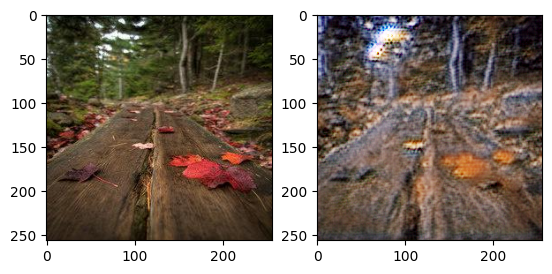

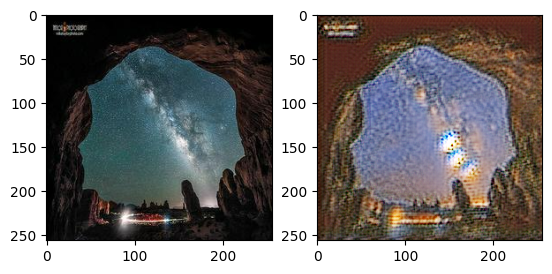

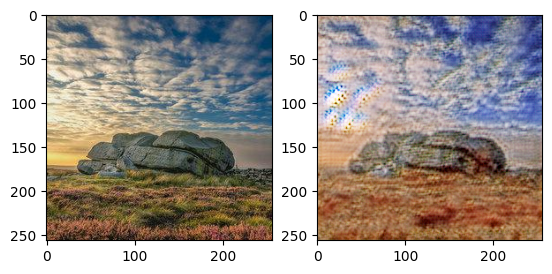

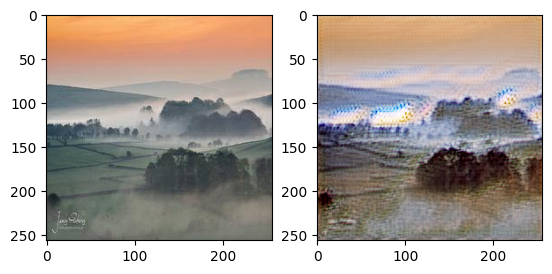

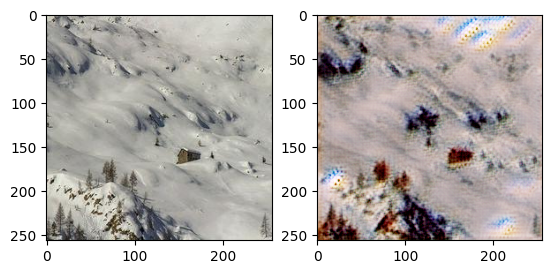

In [21]:
for idx, (monet, photo) in enumerate(loader):
    monet = monet.to(device)
    photo = photo.to(device)
    fake_photo = gen_P(monet)
    fake_monet = gen_M(photo).cpu().detach()[0]

    plt.subplot(121)
    plt.imshow(photo.cpu().detach()[0].squeeze().permute(1, 2, 0) )
    plt.subplot(122)
    plt.imshow(fake_monet.squeeze().permute(1, 2, 0))

    plt.show()
    if idx == 4:
      break

#### Plots

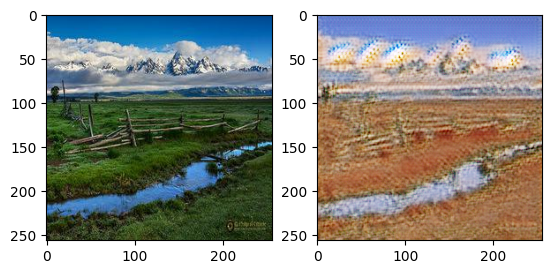

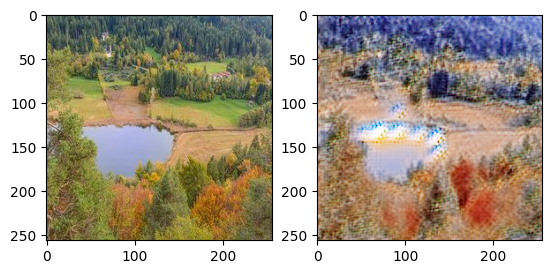

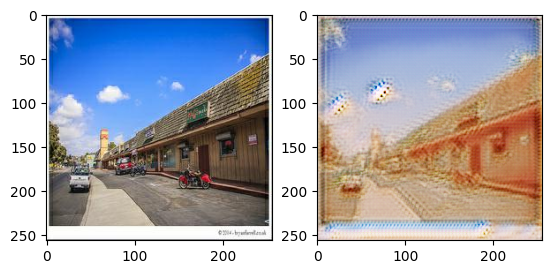

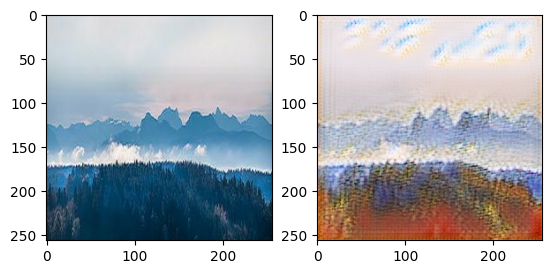

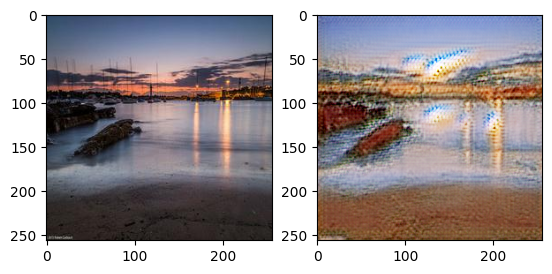

In [25]:
for idx, (monet, photo) in enumerate(loader):
    monet = monet.to(device)
    photo = photo.to(device)
    fake_photo = gen_P(monet)
    fake_monet = gen_M(photo).cpu().detach()[0]

    plt.subplot(121)
    plt.imshow(photo.cpu().detach()[0].squeeze().permute(1, 2, 0) )
    plt.subplot(122)
    plt.imshow(fake_monet.squeeze().permute(1, 2, 0) )

    plt.show()
    if idx == 4:
        break

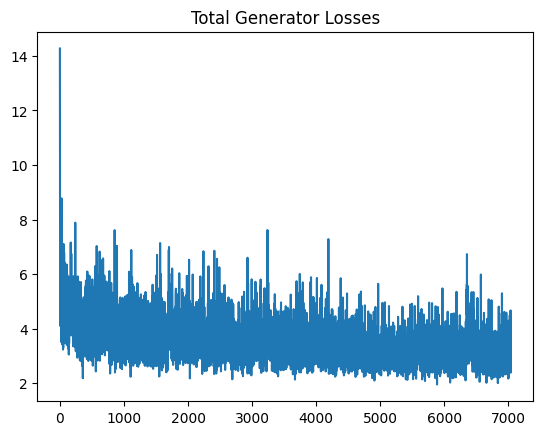

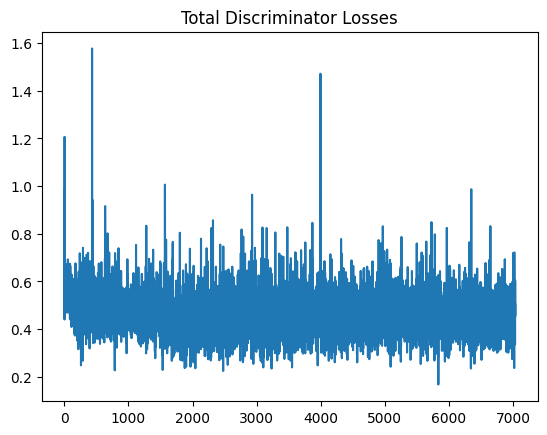

In [26]:
plt.plot(G_loss_arr, label = 'Generator photo Loss')
plt.title("Total Generator Losses")
plt.show()

plt.plot(D_loss_arr, label = 'Discriminator photo Loss')
plt.title("Total Discriminator Losses")
plt.show()

In [36]:
# # %%script echo skipping
import pickle

pickle.dump(gen_M,open("/content/gen_M.pkl",'wb'))

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!cp /content/gen_M.pkl /content/drive/MyDrive/tree

Mounted at /content/drive
